In [17]:
import numpy as np
import pandas as pd
import scipy
import scipy.io
import scipy.signal
import copy
import os
import sys
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
import time
import datetime
import urllib
from urllib.request import urlopen
import requests
import json
from sunpy.time import parse_time
from sunpy.coordinates import HeliocentricInertial, HeliographicStonyhurst, HeliocentricEarthEcliptic
import astropy
import astropy.units as u
from astropy.constants import au
from astropy.time import Time, TimeDelta
import pickle
import cdflib
import spiceypy
import astrospice
from astrospice.net.reg import RemoteKernel, RemoteKernelsBase
from numba import njit
import heliopy.data.cassini as cassinidata
import heliopy.data.helios as heliosdata
import heliopy.data.spice as spicedata
import heliopy.spice as spice
import math
import h5py
from bs4 import BeautifulSoup 
from heliocats import data as hd
import seaborn as sns

In [9]:
def omni_loader():
    
    '''
    downloads all omni2 data into the "data" folder
    '''

    #if overwrite>0: 
    #      print('download OMNI2 again')
    #      if os.path.exists('data/omni2_all_years.dat'): os.remove('data/omni2_all_years.dat')

    #if not os.path.exists('data/omni2_all_years.dat'):
      #see http://omniweb.gsfc.nasa.gov/html/ow_data.html
    print('load OMNI .asc into "data" directory from')
    omni2_url='https://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/modified/omni_min2023.asc'
    print(omni2_url)
    try: urllib.request.urlretrieve(omni2_url, 'data/omni_min2023.asc')
    except urllib.error.URLError as e:
        print(' ', omni2_url,' ',e.reason)
        sys.exit()


def save_omni_data():
    '''
    save variables from OMNI2 dataset as pickle

    documentation https://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/omni2.text
    omni2_url='https://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/omni2_all_years.dat'
    '''        
  
    print('start omni')
    
    omni_loader()
    #check how many rows exist in this file
    f=open('data/omni_min2023.asc')
    dataset= len(f.readlines())
    
    #make array
    o=np.zeros(dataset,dtype=[('time',object),('bx', float),('by', float),\
                ('bz', float),('bygsm', float),('bzgsm', float),('bt', float),\
                ('vt', float),('np', float),('tp', float),\
                ('ae', float),('al', float),('au', float),\
                ('symd', float),('symh', float),\
                ('x_gse', float),('y_gse', float),('z_gse', float),\
                ('x', float),('y', float),('z', float),\
                ('r', float),('lat', float),('lon', float)])
                
    o=o.view(np.recarray)  
    print(dataset, ' datapoints')   #for reading data from OMNI file
    
    j=0
    with open('data/omni_min2023.asc') as f:
        for line in f:
            line = line.split() # to deal with blank 
            
            #time - need to convert from year doy hour to datetime object
            o.time[j]=datetime.datetime(int(line[0]), 1, 1) + datetime.timedelta(int(line[1]) - 1) \
                              + datetime.timedelta(hours=int(line[2])) + datetime.timedelta(minutes=int(line[3]))

            #25 is bulkspeed F6.0, in km/s
            #o.vt[j]=line[24]
            o.vt[j]=line[21]
            if o.vt[j] == 999999.9: o.vt[j]=np.NaN
            
            #24 in file, index 23 proton density /ccm
            #o.np[j]=line[23]
            o.np[j]=line[25]
            if o.np[j] == 999.99: o.np[j]=np.NaN
            
            #23 in file, index 22 Proton temperature  /ccm
            #o.tp[j]=line[22]
            o.tp[j]=line[26]
            if o.tp[j] == 9999999.: o.tp[j]=np.NaN

            #28 in file, index 27 alpha to proton ratio
            #o.alpha[j]=line[27]
            #if o.alpha[j] == 9.999: o.alpha[j]=np.NaN
           
            #9 is total B  F6.1 also fill ist 999.9, in nT
            #o.bt[j]=line[9]
            o.bt[j]=line[13]
            if o.bt[j] == 9999.99: o.bt[j]=np.NaN

            #GSE components from 13 to 15, so 12 to 14 index, in nT
            #o.bx[j]=line[12]
            o.bx[j]=line[14]
            if o.bx[j] == 9999.99: o.bx[j]=np.NaN
            o.by[j]=line[15]
            if o.by[j] == 9999.99: o.by[j]=np.NaN
            o.bz[j]=line[16]
            if o.bz[j] == 9999.99: o.bz[j]=np.NaN
          
            #GSM
            o.bygsm[j]=line[17]
            if o.bygsm[j] == 9999.99: o.bygsm[j]=np.NaN
          
            o.bzgsm[j]=line[18]
            if o.bzgsm[j] == 9999.99: o.bzgsm[j]=np.NaN    
          
        
            #o.kp[j]=line[38]
            #if o.kp[j] == 99: o.kp[j]=np.nan
           
            #o.spot[j]=line[39]
            #if o.spot[j] ==  999: o.spot[j]=np.nan

            #o.dst[j]=line[40]
            #if o.dst[j] == 99999: o.dst[j]=np.nan

            #o.ae[j]=line[41]
            o.ae[j]=line[37]
            if o.ae[j] ==  9999: o.ae[j]=np.nan
            
            #o.ap[j]=line[49]
            #if o.ap[j] ==  999: o.ap[j]=np.nan
            
            #o.f107[j]=line[50]
            #if o.f107[j] ==  999.9  : o.f107[j]=np.nan
            
            #o.pcn[j]=line[51]
            #o.pcn[j]=line[44]
            #if o.pcn[j] ==  999.9  : o.pcn[j]=np.nan

            #o.al[j]=line[52]
            o.al[j]=line[38]
            if o.al[j] ==   99999  : o.al[j]=np.nan

            #o.au[j]=line[53]
            o.au[j]=line[39]
            if o.au[j] ==  99999 : o.au[j]=np.nan
            
            o.symd[j]=line[40]
            if o.symd[j] ==  99999 : o.symd[j]=np.nan
            
            o.symh[j]=line[41]
            if o.symh[j] ==  99999 : o.symh[j]=np.nan
            
            o.x_gse[j]=line[32]
            if o.x_gse[j] ==  9999.99 : o.x_gse[j]=np.nan

            o.y_gse[j]=line[32]
            if o.y_gse[j] ==  9999.99 : o.y_gse[j]=np.nan

            o.z_gse[j]=line[32]
            if o.z_gse[j] ==  9999.99 : o.z_gse[j]=np.nan
          
            j=j+1     
            
    print('position start')
    
    #TBD change to astrospice HEEQ    
    #@njit
    #def sphere2cart(r,lat,lon):
    #    x = r * np.sin( lat ) * np.cos( lon )
    #    y = r * np.sin( lat ) * np.sin( lon )
    #    z = r * np.cos( lat )
    #    return (x, y,z)
    
    #@njit
    #def cart2sphere(x,y,z):
    #    r = np.sqrt(x**2+ y**2 + z**2)           
    #    theta = np.arctan2(z,np.sqrt(x**2+ y**2))
    #    phi = np.arctan2(y,x)                    
    #    return (r, theta, phi)
    
    dt = TimeDelta(1.*u.minute)

    times = Time( np.arange(Time(o.time[0]), Time(o.time[-1])+dt, dt) )
    
    coords_earth = astrospice.generate_coords('Earth', times)
    coords_earth_hee = coords_earth.transform_to(HeliocentricEarthEcliptic())
    [earth_hee_x, earth_hee_y, earth_hee_z] = hd.sphere2cart(coords_earth_hee.distance.to(u.au).value, np.deg2rad(-coords_earth_hee.lat.value+90), np.deg2rad(coords_earth_hee.lon.value))
    
    o.x = earth_hee_x - o.x_gse*u.earthRad.to(u.au)
    o.y = earth_hee_y - o.y_gse*u.earthRad.to(u.au)
    o.z = earth_hee_z - o.z_gse*u.earthRad.to(u.au)
    
    o = hd.convert_HEE_to_HEEQ(o)
    [o.r, o.lat, o.lon] = hd.cart2sphere(o.x, o.y, o.z)
        
    
    header='Near Earth OMNI2 1 hour solar wind and geomagnetic indices data since 1963. ' + \
    'Obtained from https://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/modified/omni_min2023.asc  '+ \
    'Timerange: '+o.time[0].strftime("%Y-%b-%d %H:%M")+' to '+o.time[-1].strftime("%Y-%b-%d %H:%M")+'. '+\
    'The data are available in a numpy recarray, fields can be accessed by o.time, o.bx, o.vt etc. '+\
    'Missing data has been set to "np.nan". Total number of data points: '+str(o.size)+'. '+\
    'For units and documentation see: https://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/modified/hro_modified_format.txt, the '+\
    'heliospheric position of Earth was added and is given in x/y/z/r/lon/lat [AU, degree, HEEQ]. '+\
    'Made with https://github.com/cmoestl/heliocats heliocats.data.save_omni_data .'+\
    'By C. Moestl (twitter @chrisoutofspace), A. J. Weiss, and D. Stansby. File creation date: '+\
    datetime.datetime.utcnow().strftime("%Y-%b-%d %H:%M")+' UTC'
    
    
    pickle.dump([o,header], open('omni_high_res.p', 'wb') )
    
    print('done omni')
    print()

In [7]:
print(os.getcwd())

/Users/eva/Documents/PhD/sub-L1


In [10]:
omni = save_omni_data()

start omni
load OMNI .asc into "data" directory from
https://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/modified/omni_min2023.asc
525600  datapoints
position start


conversion HEE to HEEQ
HEE to HEEQ done
done omni



In [11]:
[o, oh] = pickle.load(open('omni_high_res.p', 'rb'))

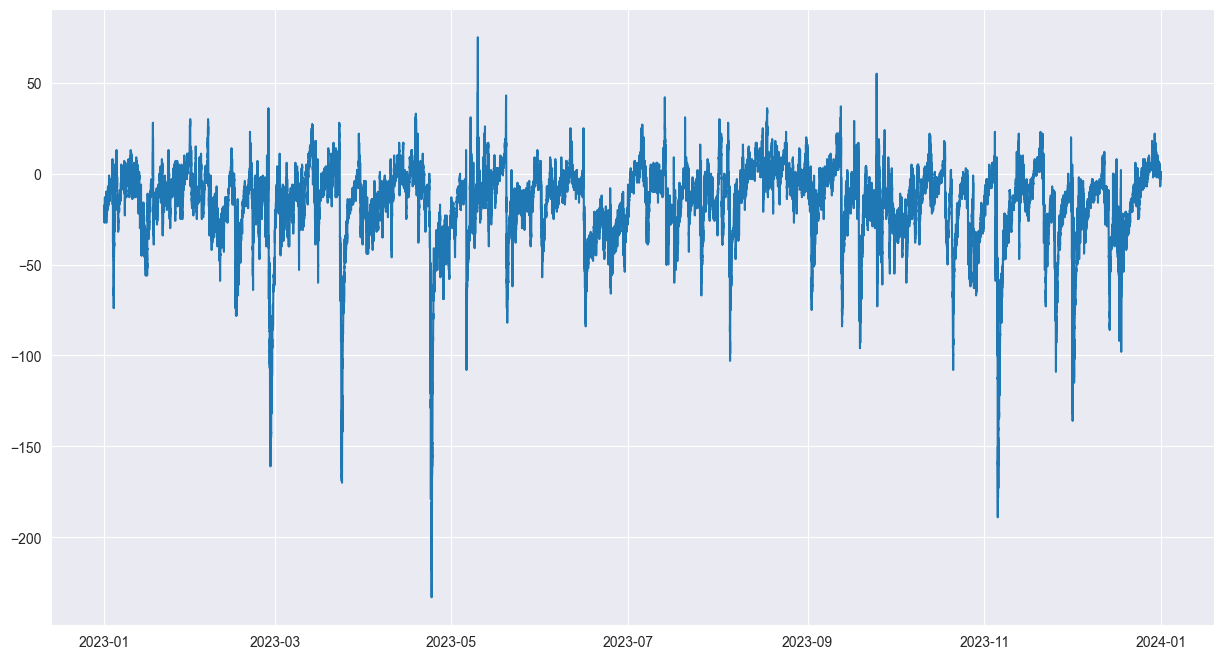

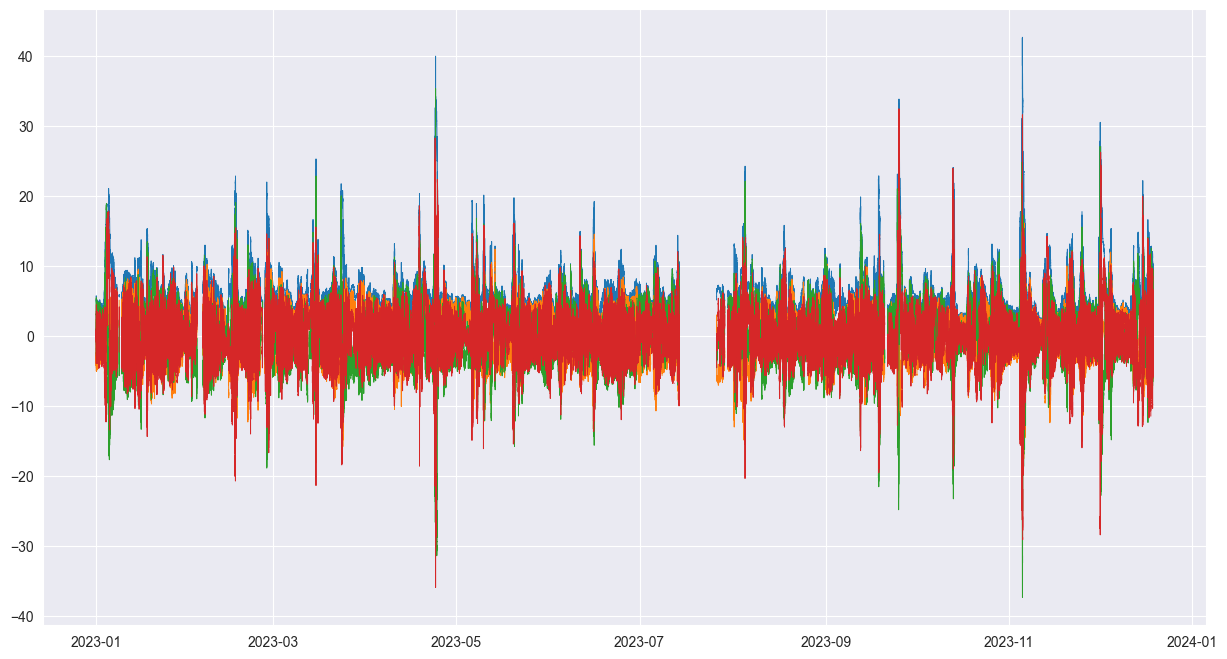

In [22]:
sns.set_style('darkgrid')

plt.figure(1, figsize=(15,8))
plt.plot(o.time, o.symh)

plt.figure(2, figsize=(15,8))
plt.plot(o.time, o.bt,lw=.7)

plt.figure(2, figsize=(15,8))
plt.plot(o.time, o.bx, lw=.7)

plt.figure(2, figsize=(15,8))
plt.plot(o.time, o.by, lw=.7)

plt.figure(2, figsize=(15,8))
plt.plot(o.time, o.bz, lw=.7)